In [5]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae import MaskedAutoEncoder  # Import your MAE model (adjust path if necessary)
from einops.layers.torch import Rearrange


In [6]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device: ", device)

Using device:  cuda


In [7]:
BATCH_SIZE = 64

In [8]:
# Custom dataset for grayscale images (1 channel)
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get list of image file paths (adjust extension if needed)
        self.image_paths = glob(os.path.join(root_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Read the image using torchvision.io.read_image and normalize to [0, 1]
        image = read_image(img_path).float() / 255.0  # Image in 1 channel (grayscale)
        if self.transform:
            image = self.transform(image)
        return image

In [9]:

# Define the image transformations (resize to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True)
])

# Define paths for data directories
data_dir = "/home/alcindo/projeto/masked-autoencoders-cows/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

# Create dataset instances
train_dataset = ImageDataset(root_dir=train_dir, transform=transform)
val_dataset = ImageDataset(root_dir=val_dir, transform=transform)

# Create DataLoaders with multi-processing and pinned memory for efficiency
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [10]:

# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoEncoder(
    emb_size=64, 
    decoder_emb_size=32, 
    patch_size=16, 
    num_head=8,
    encoder_num_layers= 6, 
    decoder_num_layers=4, 
    in_channels=1, 
    img_size=224).to(device)

# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)





In [7]:

# Training loop
num_epochs = 30


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images in train_loop:
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images in val_loop:
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # Save checkpoint after each epoch
    # torch.save(model.state_dict(), f"mae_checkpoint_epoch{epoch+1}.pth")

print("Training complete!")

KeyboardInterrupt: 

In [16]:
#save model

torch.save(model.state_dict(), "./checkpoints/mae_checkpoint.pth")

In [11]:
# load model

checkpoint = torch.load("./checkpoints/mae_checkpoint.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:

# split the images located in the batch into patches images[128, 1, 224, 224]-> (128, 1, num_patches, patch_size, patch_size)

def split_images(images, patch_size):
    # Get the image size
    H, W = images.shape[-2:]
    # Calculate the n6umber of patches in height and width
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # Split the images into patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(images.size(0), images.size(1), num_patches_h*num_patches_w, patch_size, patch_size)
    return patches

def apply_mask_to_patches(images, patches, masks, patch_size):
    """
    Substitui os patches mascarados por uma matriz de 1s.

    images: tensor original [B, C, H, W]
    patches: tensor de patches [B, C, num_patches, patch_size, patch_size]
    masks: tensor de máscara [B, num_patches] (0 para manter, 1 para mascarar)
    patch_size: tamanho dos patches
    """
    B, C, num_patches, H, W = patches.shape  # [128, 1, 196, 16, 16]

    # Criar tensor de 1s do mesmo tamanho de patches
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Aplicar máscara manualmente usando loops
    for b in range(masks.shape[0]):  # Para cada imagem no batch
        for i in range(masks.shape[1]):  # Para cada patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Substituir por 1s

    # Reconstruir as imagens mascaradas
    num_patches_per_row = int(images.shape[-1] // patch_size)  # Ex: 224 / 16 = 14 patches por linha
    masked_images = masked_patches.view(B, C, num_patches_per_row, num_patches_per_row, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images

def visualize_images(original,recon_images):
    """
    Plota imagens originais e mascaradas.
    """
    B = 3
    fig, axes = plt.subplots(B, 2,figsize=(10, 5 * B))

    if B == 1:
        axes = [axes]

    for i in range(B):
        # Imagem original
        axes[i][0].imshow(original[i].cpu().detach().numpy(), cmap="gray")
        axes[i][0].set_title("original projected")
        axes[i][0].axis("off")

        # Imagem reconstruída
        axes[i][1].imshow(recon_images[i].cpu().numpy(), cmap="gray")
        axes[i][1].set_title("reconstruction projected")
        axes[i][1].axis("off")

    plt.show()






In [21]:

# select a batch from validation set

images = next(iter(val_loader)).to(device)



model.eval()

with torch.no_grad():
    _, recon_images, masks = model(images)


# Split the images into patches
patches = split_images(images, patch_size=16)

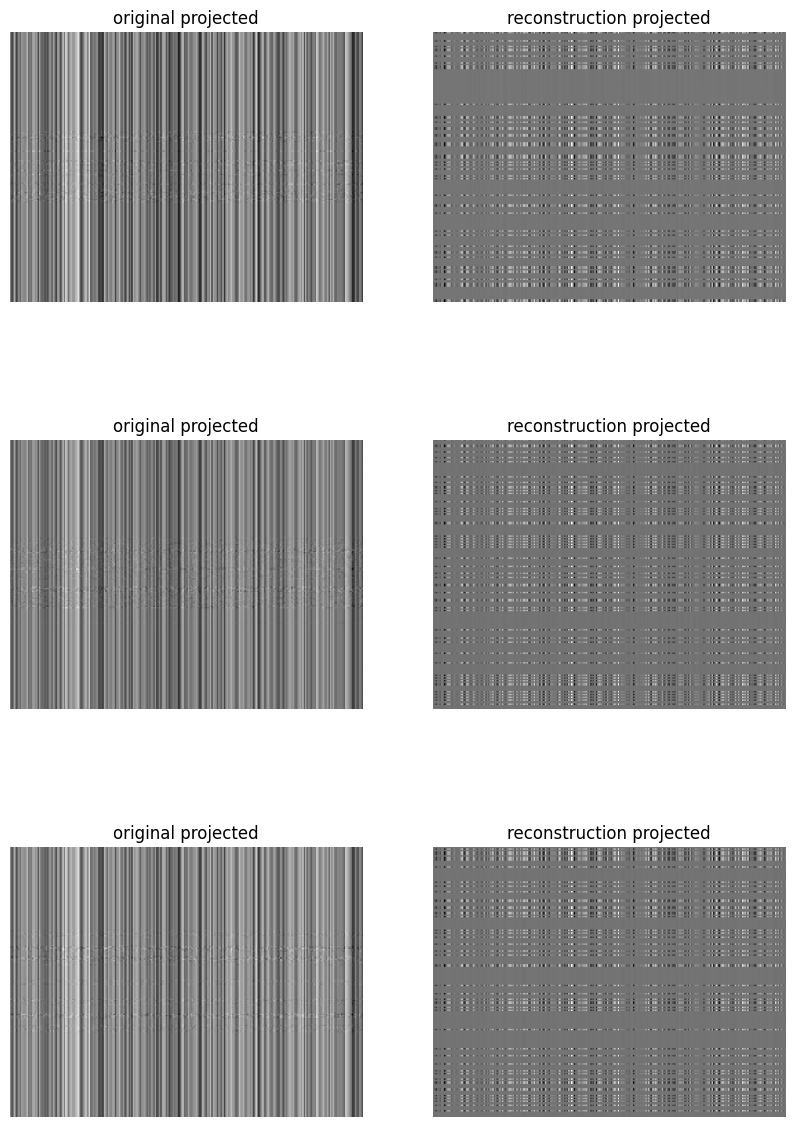

In [22]:
# Aplicar máscara às imagens
masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 16)


# Visualizar
visualize_images(model.project(images), recon_images)